In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import random
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.uniform.Uniform(0,15)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]


In [4]:
#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
dec = MLPDecoder(N,200)
r = enc.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

Text(0, 0.5, 'Encoding')

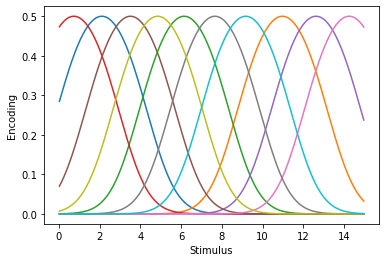

In [5]:
#Initialized encoder before training
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [6]:
##functions for the losses
q = rate_ising(N)
loss = q(enc,x_fine)
dist = distortion_gaussian(x_fine,enc,dec)

GRADIENT DESCENT ON THE WHOLE SET OF PARAMETERS ( encoder, decoder, h, J)    

In [7]:
#Traning on the entire set of parameters
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(enc.parameters(),q.parameters(), dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        rate = q(enc,x_)
        dist = distortion_gaussian(x_,enc,dec)
        loss = rate + dist
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())


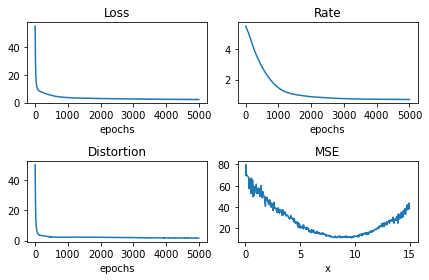

In [10]:
r = enc.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()


In [35]:
r = enc.sample(x_sorted,100)
mu_dec, sigma_dec = dec(r)
mu_dec.shape

torch.Size([500, 100])

Text(0, 0.5, 'Encoding')

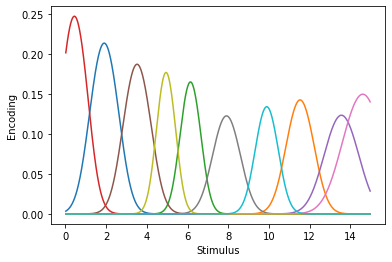

In [11]:
#Tuning curves with learned parameters
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

I want to find the best parameters h and J that minimize the rate considering a fixed encoder whose parameters are kept equal to the initialized ones (first step of EM). 
The parameters being optimized are then the decoder's ones + h and J

In [12]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(q.parameters(), dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        rate = q(enc,x_)
        dist = distortion_gaussian(x_,enc,dec)
        loss = rate + dist
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())


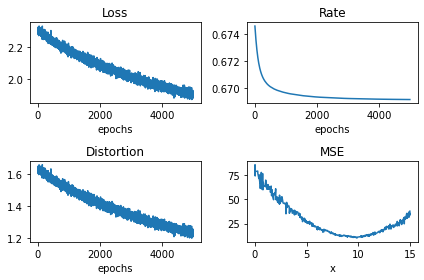

In [13]:
r = enc.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()

In [14]:
q.h
q.J


Parameter containing:
tensor([[ 0.0000, -2.7996, -2.7668,  0.4613, -2.9659,  0.2135, -2.7905, -2.5245,
         -2.7239, -2.6974],
        [-2.7996,  0.0000, -2.7659, -2.7596, -0.1478, -2.7246, -0.9184, -2.5499,
         -2.8875,  0.0495],
        [-2.7668, -2.7659,  0.0000, -2.7993, -2.6219, -1.5680, -2.7645, -0.2216,
          0.1484, -2.9496],
        [ 0.4613, -2.7596, -2.7993,  0.0000, -2.7883, -2.0317, -2.8148, -2.8019,
         -2.9976, -2.7515],
        [-2.9659, -0.1478, -2.6219, -2.7883,  0.0000, -2.7474,  0.7555, -2.6709,
         -2.7180, -2.4980],
        [ 0.2135, -2.7246, -1.5680, -2.0317, -2.7474,  0.0000, -2.6528, -2.6730,
          0.2176, -2.6820],
        [-2.7905, -0.9184, -2.7645, -2.8148,  0.7554, -2.6528,  0.0000, -2.6492,
         -2.7528, -2.6941],
        [-2.5245, -2.5499, -0.2216, -2.8019, -2.6709, -2.6730, -2.6492,  0.0000,
         -2.4450, -0.2664],
        [-2.7239, -2.8875,  0.1484, -2.9976, -2.7180,  0.2176, -2.7528, -2.4450,
          0.0000, -2.6478

In [15]:
W = np.sqrt(1/N)*torch.randn(N,N)
J0 = W*W.transpose(0,1)
J0.fill_diagonal_(0)

tensor([[ 0.0000e+00,  4.6195e-01, -2.2192e-02, -1.3879e-01,  5.0082e-01,
         -2.8314e-02, -3.1335e-02, -1.6896e-02, -8.2921e-04, -4.3996e-02],
        [ 4.6195e-01,  0.0000e+00,  2.0336e-01,  1.1149e-01,  5.8657e-02,
          1.5901e-02,  4.8719e-03,  3.9448e-02,  1.8821e-02, -1.3091e-02],
        [-2.2192e-02,  2.0336e-01,  0.0000e+00, -1.3727e-03, -1.9196e-04,
          2.1336e-02, -1.4195e-02,  1.1461e-01, -2.2470e-01, -9.1213e-03],
        [-1.3879e-01,  1.1149e-01, -1.3727e-03,  0.0000e+00, -1.9828e-02,
         -7.1324e-03,  5.5119e-02,  1.3858e-01,  1.7661e-01,  2.8038e-02],
        [ 5.0082e-01,  5.8657e-02, -1.9196e-04, -1.9828e-02,  0.0000e+00,
          6.4496e-03,  6.0908e-02, -6.3636e-03,  1.0822e-01,  1.2538e-01],
        [-2.8314e-02,  1.5901e-02,  2.1336e-02, -7.1324e-03,  6.4496e-03,
          0.0000e+00,  6.1505e-03,  2.1515e-01,  4.4937e-02,  3.4900e-03],
        [-3.1335e-02,  4.8719e-03, -1.4195e-02,  5.5119e-02,  6.0908e-02,
          6.1505e-03,  0.0000e+0

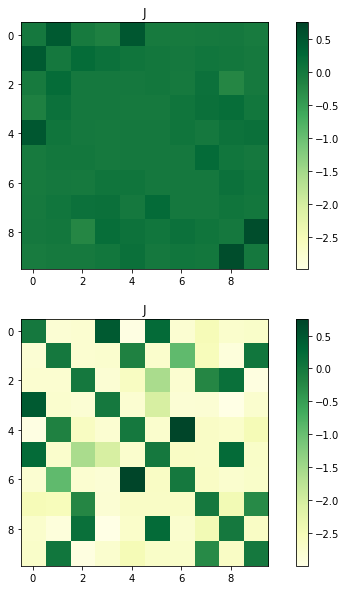

In [16]:
a = (q.J).detach()
show_plots([J0, a])



fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
cmap = cm.Reds

fig.add_subplot(rows, columns, 1)
plt.imshow(J0, cmap)
plt.title("J0")
plt.colorbar()

cmap = cm.Blues
fig.add_subplot(rows, columns, 2)
plt.imshow(a, cmap)
plt.title("Optimal J")
plt.colorbar()

Given the optimal h and J, I want to see how the rate changes when varying the sigmas of the encoding process tuning curves.


In [17]:
opt_h = q.h
opt_J = q.J
opt_J

Parameter containing:
tensor([[ 0.0000, -2.7996, -2.7668,  0.4613, -2.9659,  0.2135, -2.7905, -2.5245,
         -2.7239, -2.6974],
        [-2.7996,  0.0000, -2.7659, -2.7596, -0.1478, -2.7246, -0.9184, -2.5499,
         -2.8875,  0.0495],
        [-2.7668, -2.7659,  0.0000, -2.7993, -2.6219, -1.5680, -2.7645, -0.2216,
          0.1484, -2.9496],
        [ 0.4613, -2.7596, -2.7993,  0.0000, -2.7883, -2.0317, -2.8148, -2.8019,
         -2.9976, -2.7515],
        [-2.9659, -0.1478, -2.6219, -2.7883,  0.0000, -2.7474,  0.7555, -2.6709,
         -2.7180, -2.4980],
        [ 0.2135, -2.7246, -1.5680, -2.0317, -2.7474,  0.0000, -2.6528, -2.6730,
          0.2176, -2.6820],
        [-2.7905, -0.9184, -2.7645, -2.8148,  0.7554, -2.6528,  0.0000, -2.6492,
         -2.7528, -2.6941],
        [-2.5245, -2.5499, -0.2216, -2.8019, -2.6709, -2.6730, -2.6492,  0.0000,
         -2.4450, -0.2664],
        [-2.7239, -2.8875,  0.1484, -2.9976, -2.7180,  0.2176, -2.7528, -2.4450,
          0.0000, -2.6478

In [18]:
#Analysis varying the widths of the tuning curves


class BernoulliEncoder(torch.nn.Module):
    # Encoder returning for N neurons their unnormalized probabilities of being active (i.e. logits),as 
    # a quadratic function of x
    def __init__(self,N,x_min,x_max,xs,w):
        super().__init__()
        self.cs, self.log_sigmas,self.As  = initialize_bernoulli_params_sigma(N,x_min,x_max,xs,w)
    def forward(self,x):
        # x has shape [bsize_dim,x_dim], c,log_sigma,A has shape [x_dim, N]
        inv_sigmas = 0.5*torch.exp(-2*self.log_sigmas)
        etas = -(x**2)@inv_sigmas
        etas2 = + 2*x@((self.cs*inv_sigmas))
        etas3 = - (self.cs**2)*inv_sigmas + torch.log(self.As)
        return etas + etas2 + etas3

    def sample(self,x,nsamples):
        p_r_x = torch.distributions.bernoulli.Bernoulli(logits = self.forward(x))
        r = p_r_x.sample((nsamples,)).transpose(0,1)
        return r

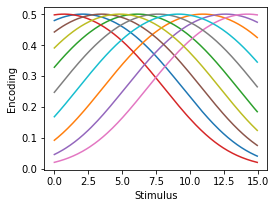

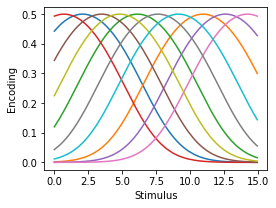

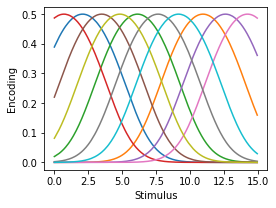

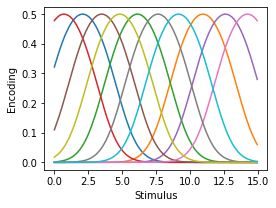

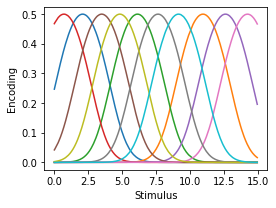

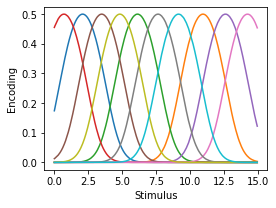

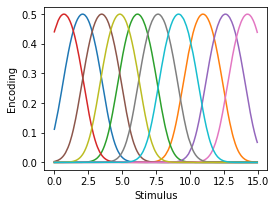

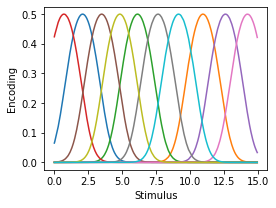

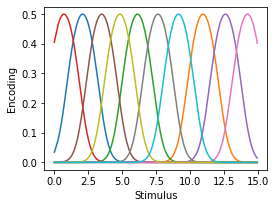

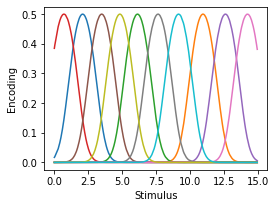

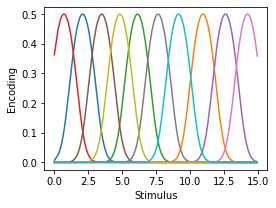

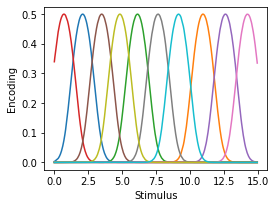

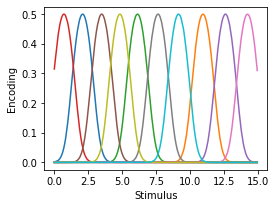

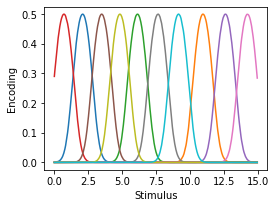

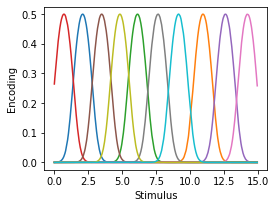

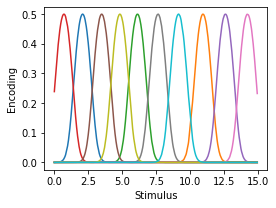

In [19]:
#Visualizing how the tuning curves vary when I vary w
for w in range(3,35,2):
    fig = plt.figure(figsize=(4, 3))
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    fig.add_subplot()
    plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding")

In [20]:
rateVec = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    qq = rate_ising(N)
    qqq = qq(enc, x_sorted)
    rateVec.append(qqq.item())

sigmas = []
for w in range(3,30,2):
    sigma = (x_max-x_min)/w
    sigmas.append(sigma)

Text(0.5, 1.0, 'Rate as a function of curve width')

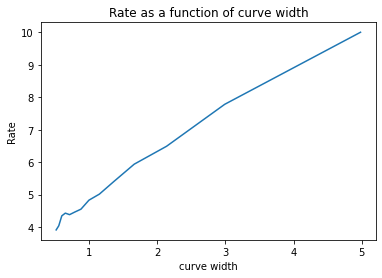

In [21]:
plt.plot(sigmas,rateVec)
plt.xlabel("curve width")
plt.ylabel("Rate")
plt.title("Rate as a function of curve width")

In [22]:
#learning sui parametri del rate
rateVec = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
    params = itertools.chain(q.parameters())
    lr = 1e-3
    opt = torch.optim.Adam(params,lr)

    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = q(enc,x_)
           #dist = distortion_gaussian(x_,enc,dec)
           loss = rate
    
           opt.zero_grad()
           loss.backward()
           opt.step()
        
           
    rateVec.append(rate.item())


Text(0.5, 1.0, 'Rate as a function of sigma')

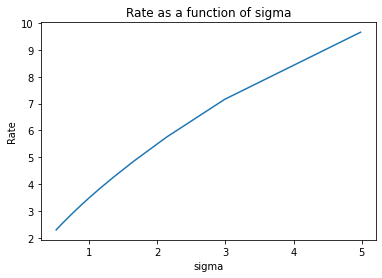

In [23]:
plt.plot(sigmas, rateVec)
plt.xlabel("sigma")
plt.ylabel("Rate")
plt.title("Rate as a function of sigma")

I want to check how J varies when the sigmas are varied. The encoder is fixed, I'm performing gradient descent only on h,J and the decoder parameters

In [24]:
#try: gradient descent only on h and J (rate)
Js_sigma = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    q = rate_ising(N)
    rate = q(enc,x_sorted)
    q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
    params = itertools.chain(q.parameters(), dec.parameters())
    lr = 1e-3
    opt = torch.optim.Adam(params,lr)

    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = q(enc,x_)
           dist = distortion_gaussian(x_,enc,dec)
           loss = rate + dist
    
           opt.zero_grad()
           loss.backward()
           opt.step()
        
    J_item = q.J.detach()
    Js_sigma.append(J_item)


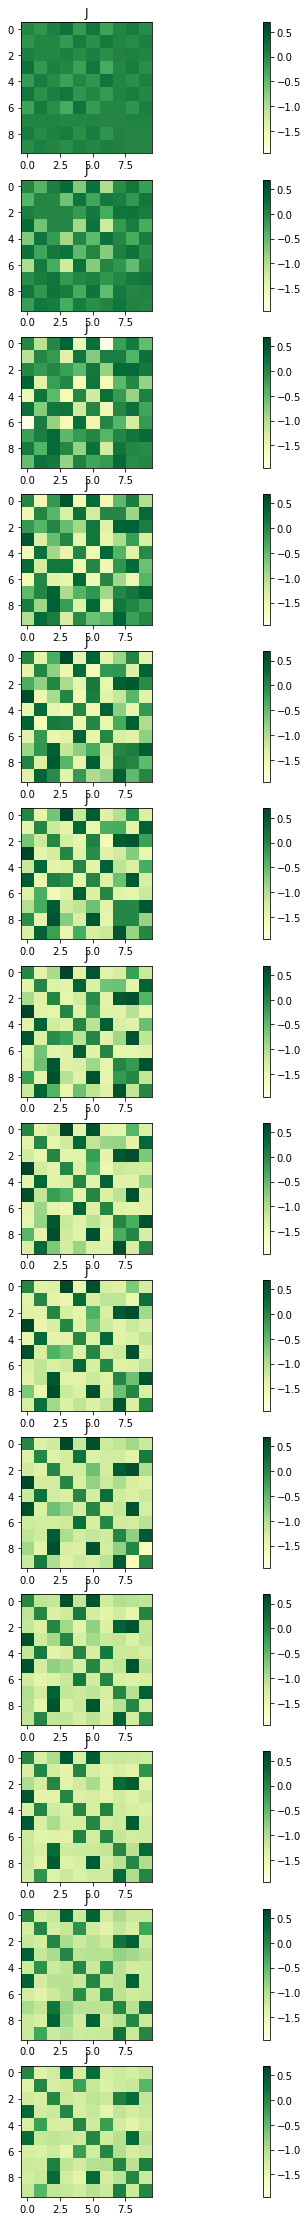

In [25]:
def show_plots(elements):
    
    combined_data = torch.stack(elements).detach().numpy()
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(40,40))
    for i in range(len(elements)):
        ax = fig.add_subplot(len(elements), 1, i+1)
        #Add the vmin and vmax arguments to set the color scale
        im=ax.imshow(elements[i],cmap=plt.cm.YlGn, vmin = _min, vmax = _max)
        ax.set_title("J")
        fig.colorbar(im, ax=ax)
        #ax.autoscale(True)

    plt.show()


show_plots(Js_sigma)

I repeat the same analysis I've just performed varying the curves' widths and analyzing the correspective J matrices, but this time varying their centroids.

In [26]:
class BernoulliEncoder(torch.nn.Module):
    # Encoder returning for N neurons their unnormalized probabilities of being active (i.e. logits),as 
    # a quadratic function of x
    def __init__(self,N,x_min,x_max,xs,w):
        super().__init__()
        self.cs, self.log_sigmas,self.As  = initialize_bernoulli_params_mu(N,x_min,x_max,xs,w)
    def forward(self,x):
        # x has shape [bsize_dim,x_dim], c,log_sigma,A has shape [x_dim, N]
        inv_sigmas = 0.5*torch.exp(-2*self.log_sigmas)
        etas = -(x**2)@inv_sigmas
        etas2 = + 2*x@((self.cs*inv_sigmas))
        etas3 = - (self.cs**2)*inv_sigmas + torch.log(self.As)
        return etas + etas2 + etas3

    def sample(self,x,nsamples):
        p_r_x = torch.distributions.bernoulli.Bernoulli(logits = self.forward(x))
        r = p_r_x.sample((nsamples,)).transpose(0,1)
        return r

Parameter containing:
tensor([[-0.1784,  1.3564,  2.8912,  4.4260,  5.9608,  7.4956,  9.0304, 10.5651,
         12.0999, 13.6347]], requires_grad=True)
Parameter containing:
tensor([[-0.1784,  1.2564,  2.6912,  4.1260,  5.5608,  6.9956,  8.4304,  9.8651,
         11.2999, 12.7347]], requires_grad=True)
Parameter containing:
tensor([[-0.1784,  1.1564,  2.4912,  3.8260,  5.1608,  6.4956,  7.8304,  9.1651,
         10.4999, 11.8347]], requires_grad=True)
Parameter containing:
tensor([[-0.1784,  1.0564,  2.2912,  3.5260,  4.7608,  5.9956,  7.2304,  8.4651,
          9.6999, 10.9347]], requires_grad=True)
Parameter containing:
tensor([[-0.1784,  0.9564,  2.0912,  3.2260,  4.3608,  5.4956,  6.6304,  7.7651,
          8.8999, 10.0347]], requires_grad=True)
Parameter containing:
tensor([[-0.1784,  0.8564,  1.8912,  2.9260,  3.9608,  4.9956,  6.0304,  7.0651,
          8.0999,  9.1347]], requires_grad=True)
Parameter containing:
tensor([[-0.1784,  0.7564,  1.6912,  2.6260,  3.5608,  4.4956,  5.

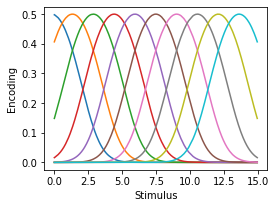

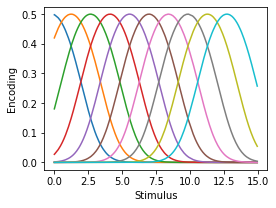

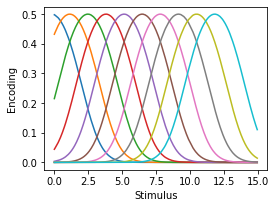

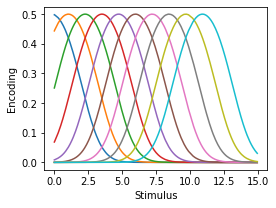

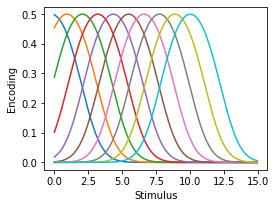

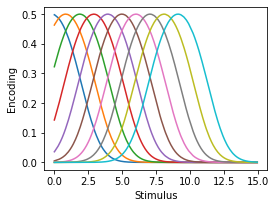

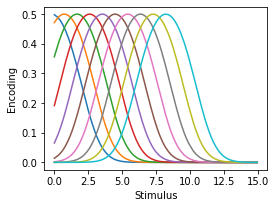

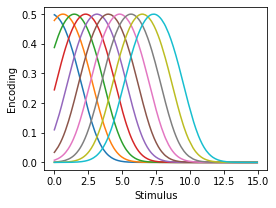

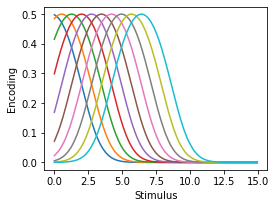

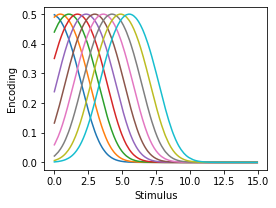

In [27]:
#Visualizing how the tuning curves vary when I vary w
for w in range(0,10,1):
    fig = plt.figure(figsize=(4, 3))
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    fig.add_subplot()
    plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding")
    print(enc.cs)

In [29]:
Js_mu = []
for w in range(0,10,1):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    q = rate_ising(N)
    rate = q(enc,x_sorted)
    q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
    params = itertools.chain(q.parameters(), dec.parameters())
    lr = 1e-3
    opt = torch.optim.Adam(params,lr)
    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = q(enc,x_)
           dist = distortion_gaussian(x_,enc,dec)
           loss = rate + dist
           opt.zero_grad()
           loss.backward()
           opt.step()
       
    J_item = q.J.detach()
    Js_mu.append(J_item)


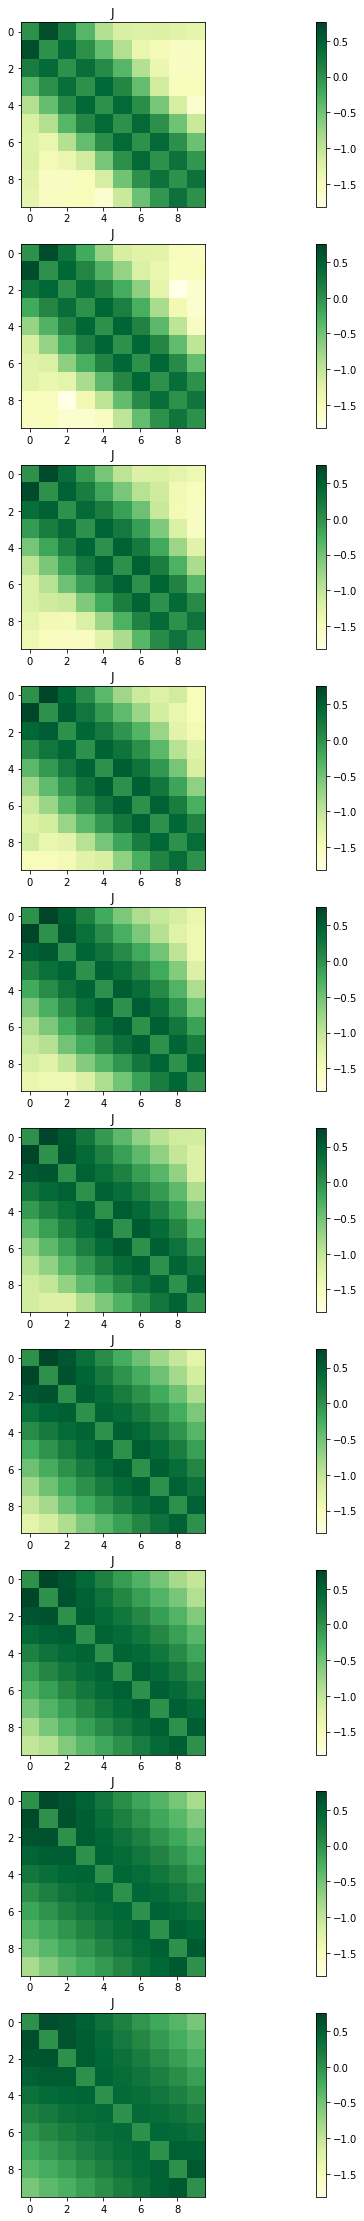

In [30]:
show_plots(Js_mu)